# EDA

As a result of this EDA, we have taken the following __methodological decisions__:
* 50 observations (1%) deleted for containing missing data
* Log-transform BoxOffice, runtimeMinutes and numVotes

***


In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

from numpy import log
from scipy.stats import skew, shapiro

import missingno as mn

import statsmodels.api as sm

In [127]:
data = pd.read_parquet('../10-data/data_final.parquet')

In [128]:
#ProfileReeóport(data)

<Axes: >

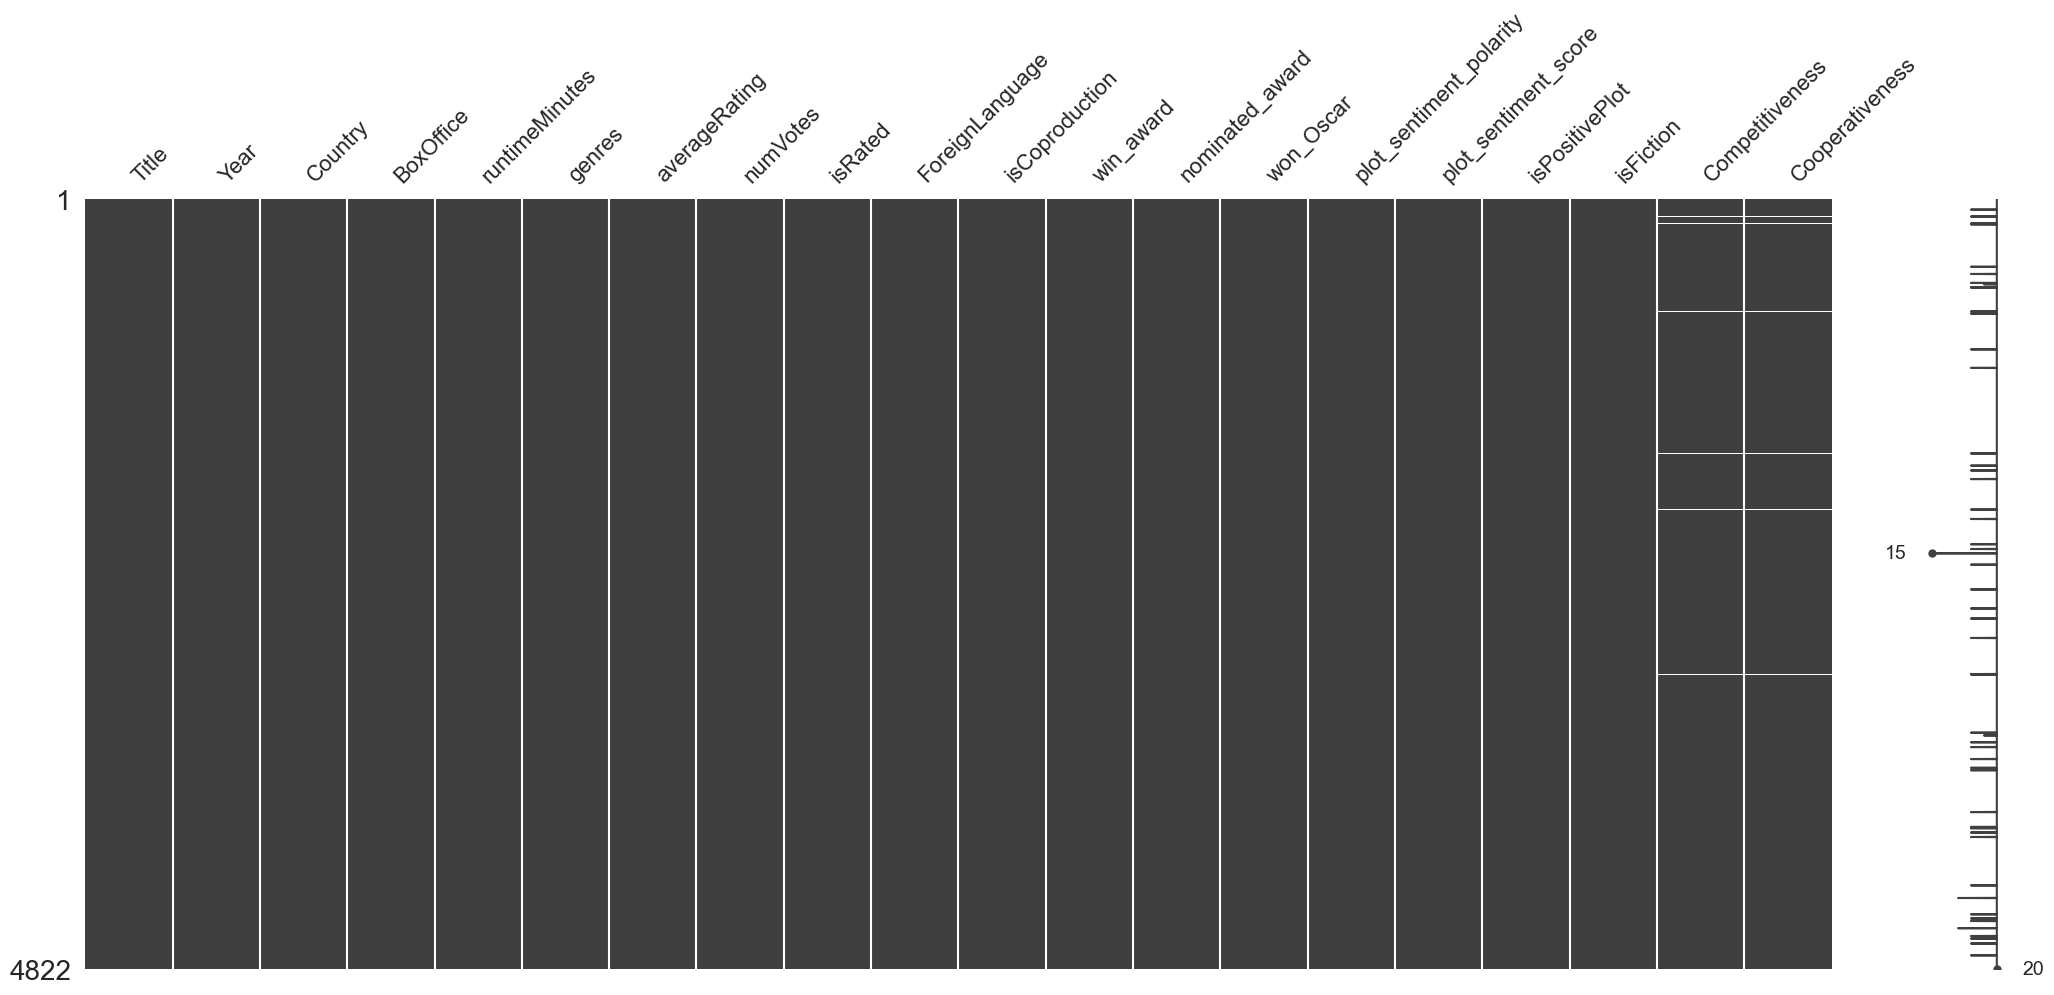

In [129]:
mn.matrix(data)

In [130]:
data.isna().sum()

Title                       0
Year                        0
Country                     0
BoxOffice                   0
runtimeMinutes              2
genres                      0
averageRating               0
numVotes                    0
isRated                     0
ForeignLanguage             0
isCoproduction              0
win_award                   0
nominated_award             0
won_Oscar                   0
plot_sentiment_polarity     3
plot_sentiment_score        3
isPositivePlot              3
isFiction                   0
Competitiveness            50
Cooperativeness            50
dtype: int64

In [131]:
a, _ = data.shape
data = data.dropna()
b, _ = data.shape
print(a-b, (a-b)/a)
del a, b

54 0.011198672749896308


In [132]:
data.columns

Index(['Title', 'Year', 'Country', 'BoxOffice', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes', 'isRated', 'ForeignLanguage',
       'isCoproduction', 'win_award', 'nominated_award', 'won_Oscar',
       'plot_sentiment_polarity', 'plot_sentiment_score', 'isPositivePlot',
       'isFiction', 'Competitiveness', 'Cooperativeness'],
      dtype='object')

## Quantitative variables

In [133]:
quanti = ['BoxOffice','runtimeMinutes','averageRating', 'numVotes', 'Competitiveness', 'Cooperativeness']
data[quanti].describe()

,BoxOffice,runtimeMinutes,averageRating,numVotes,Competitiveness,Cooperativeness
count,4.768000e+03,4768.00000,4768.000000,4.768000e+03,4768.000000,4768.000000
mean,1.458306e+06,109.50818,6.589828,1.657630e+04,9.943312,9.947612
std,6.203433e+06,26.04283,0.919349,5.204826e+04,1.838847,1.917194
min,4.900000e+01,48.00000,1.700000,8.000000e+00,1.098612,2.476538
25%,2.840600e+04,94.00000,6.100000,1.329750e+03,8.552734,8.599455
50%,1.435195e+05,105.00000,6.700000,3.939000e+03,10.158909,10.001884
75%,7.188135e+05,119.00000,7.200000,1.246050e+04,11.492900,11.471678
max,1.748035e+08,808.00000,8.900000,1.055827e+06,13.093114,13.499464


### Skewness

In [134]:
for x in quanti:
    x_name = x
    x = data[x]
    s = skew(x)
    slog = skew(log(x))
    print(f'{x_name}, {s:.2f}, {slog:.2f}')

BoxOffice, 13.12, -0.03
runtimeMinutes, 6.54, 0.99
averageRating, -1.10, -2.14
numVotes, 10.27, -0.01
Competitiveness, -0.49, -1.27
Cooperativeness, -0.31, -1.00


**DECISION** Log-transform BoxOffice, runtimeMinutes and numVotes

In [135]:
data['logBoxOffice'] = log(data['BoxOffice'])
data['logRunTime'] = log(data['runtimeMinutes'])
data['logNumVotes'] = log(data['numVotes'])

quanti.extend(['logBoxOffice','logRunTime','logNumVotes'])

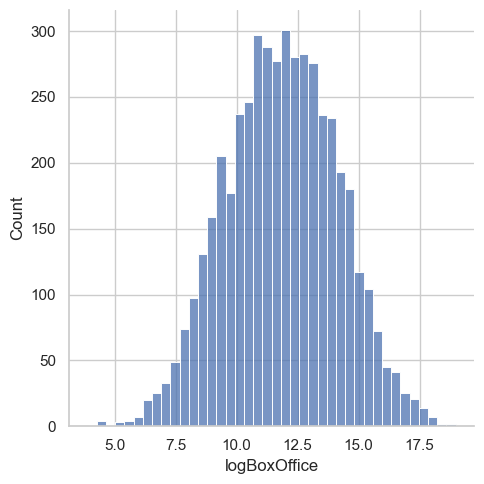

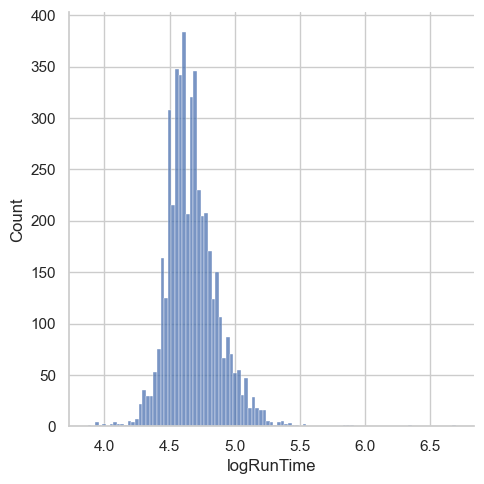

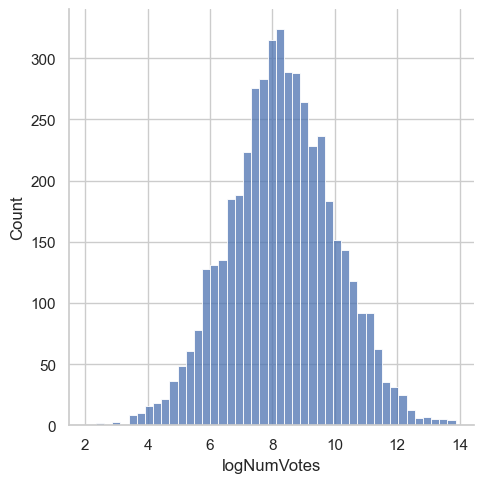

In [136]:
sns.displot(data.logBoxOffice)
sns.displot(data.logRunTime)
sns.displot(data.logNumVotes)

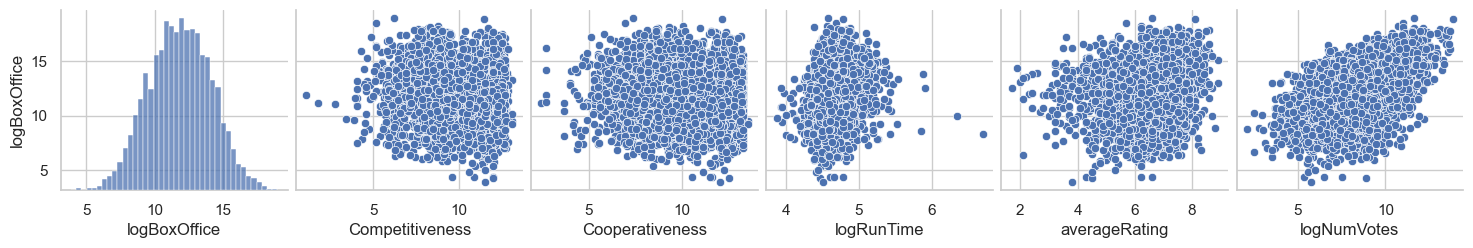

In [137]:
sns.pairplot(data[quanti],
             y_vars='logBoxOffice',
             x_vars=['logBoxOffice',
                     'Competitiveness',
                     'Cooperativeness',
                     'logRunTime',
                     'averageRating',
                     'logNumVotes'])

In [138]:
data[quanti].corr()['logBoxOffice'].sort_values(ascending=False)

logBoxOffice       1.000000
logNumVotes        0.520317
BoxOffice          0.437555
numVotes           0.326000
logRunTime         0.246886
runtimeMinutes     0.200329
averageRating      0.187303
Cooperativeness   -0.109584
Competitiveness   -0.165882
Name: logBoxOffice, dtype: float64

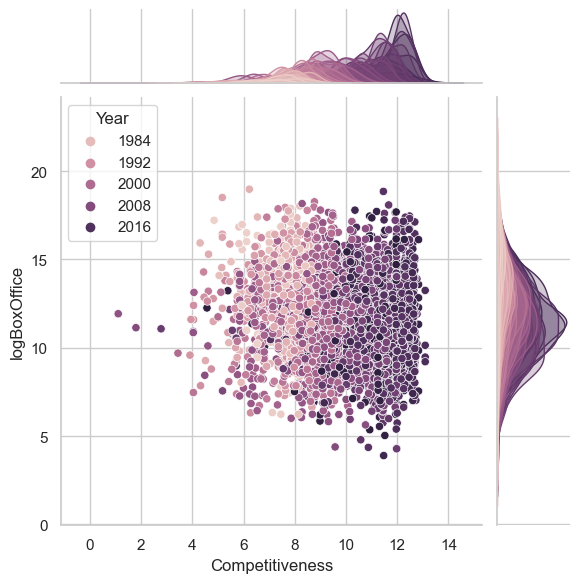

In [139]:
sns.jointplot(y='logBoxOffice',
              x = 'Competitiveness',
              hue='Year',
              data =data[['Year','Competitiveness','logBoxOffice']])

## Qualitative variables

In [140]:
data.columns

Index(['Title', 'Year', 'Country', 'BoxOffice', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes', 'isRated', 'ForeignLanguage',
       'isCoproduction', 'win_award', 'nominated_award', 'won_Oscar',
       'plot_sentiment_polarity', 'plot_sentiment_score', 'isPositivePlot',
       'isFiction', 'Competitiveness', 'Cooperativeness', 'logBoxOffice',
       'logRunTime', 'logNumVotes'],
      dtype='object')

In [141]:
quali = ['isRated', 'ForeignLanguage','isCoproduction', 'win_award', 'nominated_award', 'won_Oscar','isPositivePlot','isFiction']

In [142]:
data[quali].dtypes

isRated               bool
ForeignLanguage       bool
isCoproduction        bool
win_award             bool
nominated_award       bool
won_Oscar             bool
isPositivePlot     float64
isFiction             bool
dtype: object

In [143]:
data[quali] = data[quali].astype('int32')

### Imbalance

In [144]:
for name_x in quali:
    x = data[name_x]
    print(name_x)
    print(x.value_counts(normalize=True))

isRated
0    0.527265
1    0.472735
Name: isRated, dtype: float64
ForeignLanguage
0    0.784396
1    0.215604
Name: ForeignLanguage, dtype: float64
isCoproduction
0    0.60969
1    0.39031
Name: isCoproduction, dtype: float64
win_award
1    0.741611
0    0.258389
Name: win_award, dtype: float64
nominated_award
1    0.842282
0    0.157718
Name: nominated_award, dtype: float64
won_Oscar
0    0.986158
1    0.013842
Name: won_Oscar, dtype: float64
isPositivePlot
1    0.753146
0    0.246854
Name: isPositivePlot, dtype: float64
isFiction
1    0.96057
0    0.03943
Name: isFiction, dtype: float64


## Vanila regression

In [145]:
data.columns 

Index(['Title', 'Year', 'Country', 'BoxOffice', 'runtimeMinutes', 'genres',
       'averageRating', 'numVotes', 'isRated', 'ForeignLanguage',
       'isCoproduction', 'win_award', 'nominated_award', 'won_Oscar',
       'plot_sentiment_polarity', 'plot_sentiment_score', 'isPositivePlot',
       'isFiction', 'Competitiveness', 'Cooperativeness', 'logBoxOffice',
       'logRunTime', 'logNumVotes'],
      dtype='object')

### Controls only

In [147]:
X = data[['Year', 
         'averageRating',
         'isRated', 
         'ForeignLanguage',
         'isCoproduction', 
         'win_award', 
         'nominated_award', 
         'won_Oscar',
         'isPositivePlot', 
         #'plot_sentiment_score',
         'isFiction',
         #'Competitiveness', 
         #'Cooperativeness', 
         'logRunTime',
         #'logNumVotes'
        ]]
X = sm.add_constant(X)

y = data['logBoxOffice']

lr_controls_only = sm.OLS(y,X).fit()
print(lr_controls_only.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     145.3
Date:                Fri, 24 Nov 2023   Prob (F-statistic):          4.48e-289
Time:                        21:33:26   Log-Likelihood:                -10027.
No. Observations:                4768   AIC:                         2.008e+04
Df Residuals:                    4756   BIC:                         2.016e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              53.9101      6.093     

### X included

In [148]:
X = data[['Competitiveness', 
         'Cooperativeness',
          'Year', 
         'averageRating',
         'isRated', 
         'ForeignLanguage',
         'isCoproduction', 
         'win_award', 
         'nominated_award', 
         'won_Oscar',
         'isPositivePlot', 
         #'plot_sentiment_score',
         'isFiction', 
         'logRunTime',
         #'logNumVotes'
        ]]
X = sm.add_constant(X)

y = data['logBoxOffice']

lr = sm.OLS(y,X).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:           logBoxOffice   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     124.5
Date:                Fri, 24 Nov 2023   Prob (F-statistic):          1.84e-290
Time:                        21:34:46   Log-Likelihood:                -10019.
No. Observations:                4768   AIC:                         2.007e+04
Df Residuals:                    4754   BIC:                         2.016e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              71.7243      9.664     

In [150]:
dir(lr)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_is_nested',
 '_transform_predict_exog',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 '

In [153]:
dir(lr.summary)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']